In [3]:
import tensorflow as tf

from keras import backend  as K
from keras.models import Model
from keras import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences

from sklearn.model_selection import train_test_split
from Bio import SeqIO

import re

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

2024-03-15 12:16:12.562698: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Kaggle Dataet

In [8]:
# Data from https://www.kaggle.com/datasets/alfrandom/protein-secondary-structure

MAX_SEQ_LEN = 128

df = pd.read_csv('/home/enno/uni/SS23/thesis/data/ss_data/seq.csv')
df = df[(df.seq.str.len() <= MAX_SEQ_LEN) & (~df.has_nonstd_aa)]

len(df)

2101

<Axes: >

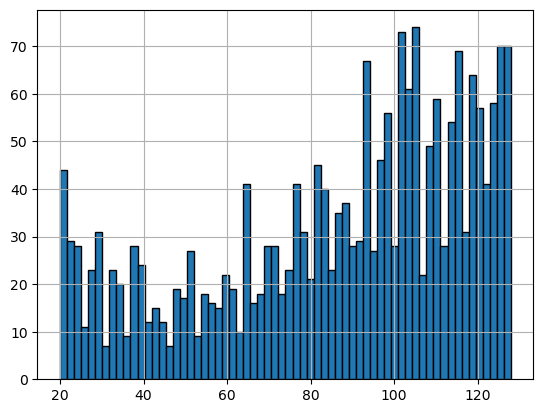

In [9]:
df.seq.apply(lambda x: len(x)).hist(bins=64, edgecolor='black')

### Hendecad Data

In [16]:
input_file = "/home/enno/uni/SS23/thesis/data/hendecads/sequences.fasta"
fasta_sequences = SeqIO.parse(open(input_file), 'fasta')

n_seq = len(list(fasta_sequences))

In [81]:
max_len = 1024

df = pd.DataFrame(columns=['id', 'seq', 'stretch_ix'])

pattern = r'\[\[.*?\]\]'

for seq_ix, seq in enumerate(SeqIO.parse(open(input_file), 'fasta')):
    print(f"Processing sequence {seq_ix+1}/{n_seq}", end='\r')

    if len(seq.seq) > max_len:
        continue
    
    s = str(seq.seq)
    d = str(seq.description)
    
    stretches = eval(re.findall(pattern, d.split('|||')[-1])[0])

    cc_ix = [x for stretch in stretches for x in np.arange(stretch[0], stretch[1]+1)]
    
    df.loc[len(df)] = [seq.id, s, cc_ix]
        

df.head()


,id,seq,stretch_ix
0,MCD6041253.1,Mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,MCD7737945.1,MQGRVFFREAAALILAAALSMAGLPASAAANSGIEAAALRTeeete...,"[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 5..."
2,MYF28459.1,Merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,WP_168920948.1,MSDVFLTASYADREKVKTLGARWNPAEKRWYVPSGRDLSPFAAWLP...,"[437, 438, 439, 440, 441, 442, 443, 444, 445, ..."
4,WP_026306873.1,MLLRRIARPLLSAAFIAEGIDILQNPGPLADRLSPALDFTRRRSQH...,"[172, 173, 174, 175, 176, 177, 178, 179, 180, ..."


In [82]:
df['seq_mask'] = df['seq'].apply(lambda seq: ''.join(['C' if s_i.islower() else 'X' for s_i in seq]))

In [83]:
tokenizer_in = Tokenizer(char_level=True)
tokenizer_in.fit_on_texts(df.seq)
vocab_size_in = len(tokenizer_in.word_index) + 1 

X = tokenizer_in.texts_to_sequences(df.seq)
X = pad_sequences(X, maxlen=max_len, padding='post')

In [84]:
tokenizer_out = Tokenizer(char_level=True)
tokenizer_out.fit_on_texts(df.seq_mask)
vocab_size_out = len(tokenizer_out.word_index) + 1

y = tokenizer_out.texts_to_sequences(df.seq_mask)
y = pad_sequences(y, maxlen=max_len, padding='post')
y = to_categorical(y)

X.shape, y.shape

((29039, 1024), (29039, 1024, 3))

In [85]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42, shuffle=True)

In [86]:
n_words = len(tokenizer_in.word_index) + 1
n_tags = len(tokenizer_out.word_index) + 1
print(n_words, n_tags)

input = Input(shape=(max_len,))
mbed = Embedding(input_dim=n_words, output_dim=128, input_length=max_len)(input)
comp = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(mbed)
final_comp = TimeDistributed(Dense(n_tags, activation="softmax"))(comp)
model = Model(input, final_comp)
model.summary()

21 3
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1024)]            0         
                                                                 
 embedding_2 (Embedding)     (None, 1024, 128)         2688      
                                                                 
 bidirectional_2 (Bidirecti  (None, 1024, 128)         98816     
 onal)                                                           
                                                                 
 time_distributed_2 (TimeDi  (None, 1024, 3)           387       
 stributed)                                                      
                                                                 
Total params: 101891 (398.01 KB)
Trainable params: 101891 (398.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [87]:
def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

In [88]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc])

model.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_test, y_test), verbose=1)

Epoch 1/5
182/182 [==============================] - 337s 2s/step - loss: 0.3172 - accuracy: 0.7927 - q3_acc: 0.5170 - val_loss: 0.2867 - val_accuracy: 0.8151 - val_q3_acc: 0.5559
Epoch 2/5
182/182 [==============================] - 346s 2s/step - loss: 0.2885 - accuracy: 0.8165 - q3_acc: 0.5662 - val_loss: 0.2783 - val_accuracy: 0.8241 - val_q3_acc: 0.5776
Epoch 3/5
151/182 [=======================>......] - ETA: 59s - loss: 0.2827 - accuracy: 0.8269 - q3_acc: 0.5912 

In [27]:
model.evaluate(X_val, y_val)


32/32 [==============================] - 1s 43ms/step - loss: 0.3017 - accuracy: 0.8693 - q3_acc: 0.7961


[0.30165258049964905, 0.8693004846572876, 0.7960553169250488]

In [45]:
def plot_prediction(i):
    p1 = np.argmax(model.predict(X_test[i:i+1]), axis=-1)[0]
    y1 = np.argmax(y_test[i:i+1], axis=-1)[0]
    
    c = np.array([p1, y1])

    _, ax = plt.subplots(figsize=(16, 1))

    sns.heatmap(c, ax=ax, cmap='viridis', xticklabels=[], linewidths=.55, linecolor='black', cbar=False)
    ax.set_yticklabels(['Predicted', 'True'], rotation=0)
    
    labels = ['P', 'C', 'X']
    colors = ['#440154', '#21918c', '#fde725']
    patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
    ax.legend(patches, labels, loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()

1/1 [==============================] - 0s 68ms/step


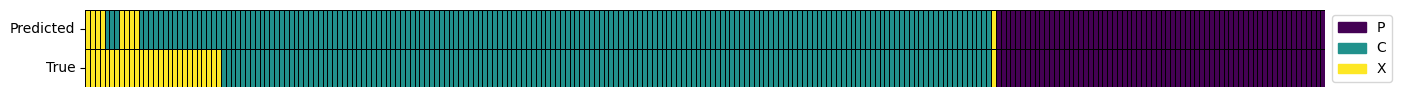

In [46]:
plot_prediction(0)

1/1 [==============================] - 0s 50ms/step


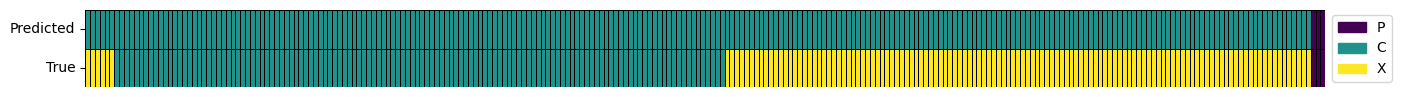

In [47]:
plot_prediction(1)

1/1 [==============================] - 0s 46ms/step


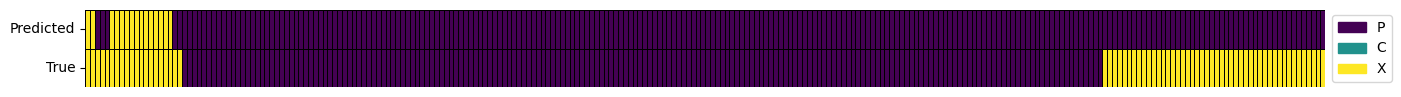

In [52]:
plot_prediction(2)

1/1 [==============================] - 0s 58ms/step


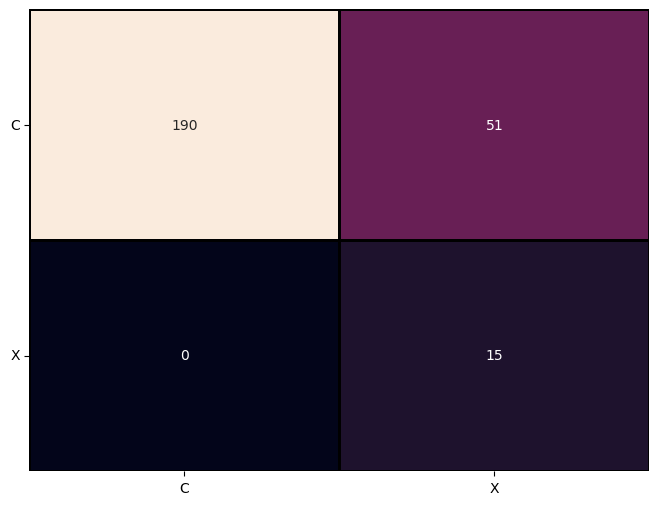

In [76]:
def plot_confusion_matrix(i):
    p1 = np.argmax(model.predict(X_test[i:i+1]), axis=-1)[0]
    y1 = np.argmax(y_test[i:i+1], axis=-1)[0]
    
    p1 = p1[y1 > 0]
    y1 = y1[y1 > 0]

    c = np.zeros((2, 2), dtype=int)
    for i in range(1, 3):
        for j in range(1, 3):
            c[i-1, j-1] = int(np.sum((p1 == i) & (y1 == j)))
        
    _, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(c, annot=True, fmt='d', linewidths=1, linecolor='black', cbar=False)

    ax.set_xticklabels(['C', 'X'])
    ax.set_yticklabels(['C', 'X'], rotation=0)

    plt.show()
    
plot_confusion_matrix(2)


1/1 [==============================] - 0s 47ms/step


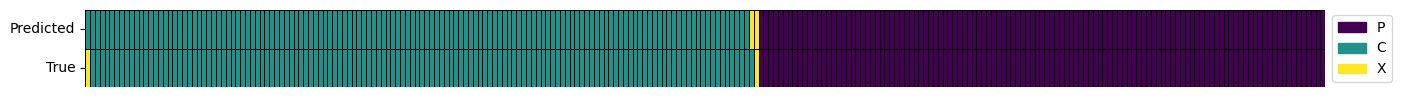

In [80]:
plot_prediction(66)

1/1 [==============================] - 0s 49ms/step


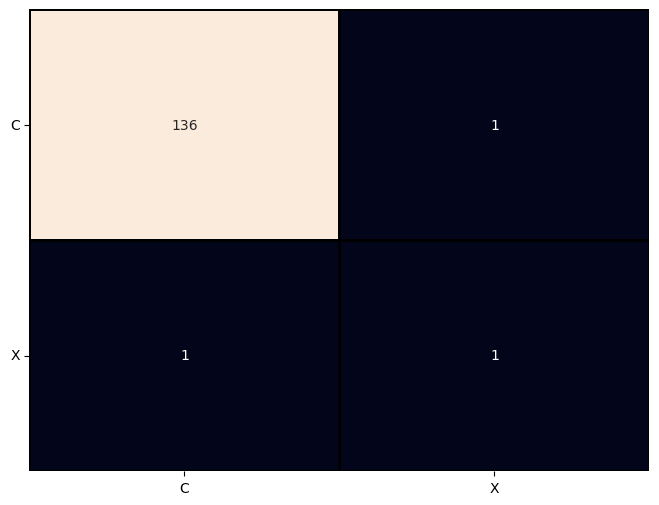

In [78]:
plot_confusion_matrix(66)

In [79]:
# Remove all whitespaces and make every letter capital
seq = ' '.join(tokenizer_in.sequences_to_texts(X_test[66:67])[0]).replace(' ', '').upper()
seq

'FENLTELYLGENEIEDLSPLRGMKQLKSLVLSGNRISDLGPLEDLDRLEYLNLNDNLISDISPLKRLVNLRRLILSANRITDISPLQDMDALTDLNLSDNMVRDIGVLEKLTELEEVNLRHNPLEDDSVLSDLDANVTY'